In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from transform_output_format import get_4D_output, get_2D_output
from utils import load_data_input
import pickle
from sklearn.model_selection import train_test_split

In [23]:
GHI,CLS,SZA,SAA,dates = load_data_input("X_train_copernicus.npz")
y_train_csv = pd.read_csv('y_train_zRvpCeO_nQsYtKN.csv')
y_train_4D = get_4D_output(y_train_csv)

In [24]:
def rolling_window(a, shape):  # rolling window for 2D array
    s = (a.shape[0] - shape[0] + 1,) + (a.shape[1] - shape[1] + 1,) + shape
    strides = a.strides + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=s, strides=strides)

In [25]:
n_window = 13
aa = rolling_window(GHI[0,0,15-n_window//2:66+n_window//2,15-n_window//2:66+n_window//2], (n_window,n_window))

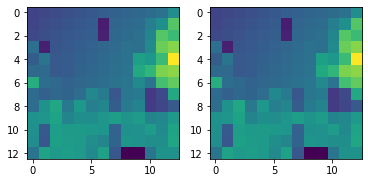

In [27]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(aa[0,1])
ax[1].imshow(GHI[0,0,15-n_window//2:15+n_window//2+1, 16-n_window//2:16+n_window//2+1])
plt.show()

In [28]:
aa.shape

(51, 51, 13, 13)

In [70]:
def rolling_window_sequence(seq,start=0, end=51, n_window=13):
    return np.stack([rolling_window(img[start-n_window//2:end+n_window//2,start-n_window//2:end+n_window//2], (n_window,n_window)) for img in seq])

In [101]:
X = np.stack([rolling_window_sequence(seq,15,66,13) for seq in GHI[:10]])
y_train_net = y_train_4D[:10].swapaxes(1,2).swapaxes(2,3).reshape(10*51*51,4)
y_train_net.shape
print(X.shape)
print(y_train_net.shape)

(10, 4, 51, 51, 13, 13)
(26010, 4)


In [32]:
X[0,:,0,0,:,:].shape

(4, 13, 13)

In [85]:
import torch.nn as nn
import torch

# flatten the tensor into 
class Flatten(nn.Module):
   def forward(self, input):
       return input.view(input.size(0), -1)

#sequential based model
seq_model = nn.Sequential(
           nn.Conv2d(4, 10, kernel_size=3, padding='same'),
           nn.MaxPool2d(2),
           nn.ReLU(),
           nn.Dropout2d(),
           nn.Conv2d(10, 20, kernel_size=3,padding='same'),
           nn.MaxPool2d(2),
           nn.ReLU(),
           nn.Conv2d(20, 10, kernel_size=5,padding='same'),
           nn.MaxPool2d(2),
           nn.ReLU(),
           nn.Conv2d(10, 4, kernel_size=5,padding='same'),
         )

net = seq_model
print(net)

Sequential(
  (0): Conv2d(4, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Dropout2d(p=0.5, inplace=False)
  (4): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): ReLU()
  (7): Conv2d(20, 10, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): ReLU()
  (10): Conv2d(10, 4, kernel_size=(5, 5), stride=(1, 1), padding=same)
)


In [86]:
input_shape = (10, 4, 13, 13)
input = torch.randn(input_shape)


In [87]:
input.shape

torch.Size([10, 4, 13, 13])

In [88]:
net(input).shape

torch.Size([10, 4, 1, 1])

In [64]:
learning_rate = 0.001
criterion = torch.nn.MSELoss()    # Softmax is internally computed.
optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate)

In [102]:
X_train = X.swapaxes(1,2).swapaxes(2,3).reshape(10*51*51,4,13,13)
y_train_net = y_train_net[:,:,np.newaxis, np.newaxis]
print(X_train.shape)
print(y_train_net.shape)

(26010, 4, 13, 13)
(26010, 4, 1, 1)


In [106]:
X_tensor = torch.Tensor(X_train)
y_tensor = torch.Tensor(y_train_net)
print(y_tensor.shape)

torch.Size([26010, 4, 1, 1])


In [108]:
X_tensor[:10].shape

torch.Size([10, 4, 13, 13])

In [112]:
training_epochs = 10
train_accu = []
train_cost = []

for epoch in range(training_epochs):
    avg_cost = 0

    optimizer.zero_grad() # <= initialization of the gradients
    
    # forward propagation
    hypothesis = net(X_tensor[:10])
    cost = criterion(hypothesis, y_tensor[:10]) # <= compute the loss function
    
    # Backward propagation
    cost.backward() # <= compute the gradient of the loss/cost function     
    optimizer.step() # <= Update the gradients
            
    # Print some performance to monitor the training
print('Learning Finished!')

Learning Finished!


In [116]:
net.eval()

Sequential(
  (0): Conv2d(4, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Dropout2d(p=0.5, inplace=False)
  (4): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): ReLU()
  (7): Conv2d(20, 10, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): ReLU()
  (10): Conv2d(10, 4, kernel_size=(5, 5), stride=(1, 1), padding=same)
)

In [118]:
net(X_tensor[15:20]).shape

torch.Size([5, 4, 1, 1])